In [1]:
from keras.applications.vgg19 import (
     VGG19, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from tqdm import tqdm
import os
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
import joblib
from collections import Counter
%matplotlib inline

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))
 
def target_category_loss_output_shape(input_shape):
    return input_shape
 
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)
 
def load_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var)
              for var, grad in zip(var_list, grads)]
 
def grad_cam(input_model, image, category_index, layer_name):
    instance_img = []
    undo_img = []
    undo_img_weight = {}
    instance_weight = []
    dict_img_weight = {}
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=x)
    loss = K.sum(model.output)
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
 
    weights = np.mean(grads_val, axis = (0, 1))

 
    for i, w in enumerate(weights):
        instance_img.append(remake_img(output[:, :, i],image))
        undo_img.append(output[:, :, i])
        instance_weight.append(w)
        dict_img_weight[w] = remake_img(output[:, :, i],image)
        undo_img_weight[w] = output[:, :, i]
    return instance_img,instance_weight,dict_img_weight,undo_img,undo_img_weight


def remake_img(cam,image):
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam)

def divPrime(num):
    lt = []
    print(num, '=', end=' ')
    while num != 1:
        for i in range(2, int(num+1)):
            if num % i == 0:
                lt.append(i)
                num = num / i
                break
    for i in range(0, len(lt)-1):
        print(lt[i], '*', end=' ')
    print(lt[-1])

Using TensorFlow backend.


In [18]:
def example_visualization(heatmap,second,path):
    weight_no = {}
    tf.compat.v1.disable_eager_execution()
    preprocessed_input = load_image(path)

    model = VGG19(weights='imagenet')

    predictions = model.predict(preprocessed_input)
    top_1 = decode_predictions(predictions)[0][0]
    print('Predicted class:')
    print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

    predicted_class = np.argmax(predictions)
    heatmap,weight,dict_form,undoimg,undoweight = grad_cam(model, preprocessed_input,predicted_class, "block5_conv3")
    if heatmap == True:
        if second == True:
            fig = plt.figure(figsize=(100, 100))
            for i,(k,v) in enumerate(dict_form.items()):
                sub = fig.add_subplot(32, 16, i + 1)
                sub.set_title(str(i) + " weight " + str(k))
                sub.imshow(v)
        else:
            fig = plt.figure(figsize=(100, 100))
            for i,(k,v) in enumerate(undoweight.items()):
                sub = fig.add_subplot(32, 16, i + 1)
                sub.set_title(str(i) + " weight " + str(k))
                sub.imshow(v)
    for i,v in zip(range(0,512),weight):
        weight_no[i] = v
    return weight_no

In [151]:
def cutimage(path_img,save_path,array_name):
    tf.compat.v1.disable_eager_execution()

    model = VGG19(weights='imagenet')
    path = path_img
    path_list = os.listdir(path)
    k_i = 0
    for i in path_list:
        if i != '.DS_Store':
            t_preprocessed_input = load_image(path +'/'+ i)

            t_predictions = model.predict(t_preprocessed_input)
            t_predicted_class = np.argmax(t_predictions)

            heatmap,weight,dict_form,undoimg,undoweight = grad_cam(model, t_preprocessed_input, t_predicted_class, "block5_conv3")

            temp_img = []
            img = image.load_img(path +'/'+ i, target_size=(224, 224))
            for m,k in tqdm(enumerate(undoimg)):

                k = cv2.resize(k, (224, 224))
                k = np.maximum(k, 0)
                heatmap_t = k / np.max(k)
                data = cv2.applyColorMap(np.uint8(255*heatmap_t), cv2.COLORMAP_SUMMER)
    #             plt.imshow(data)
                color_list = []
                for i in range(224):
                    for j in range(224):
                        if len(set([102,128,0])&set(data[i,j])) != 3:
                            color_list.append([i,j])

                x = image.img_to_array(img)
                for i in range(224):
                    for j in range(224):
                        if [i,j] not in color_list:
                            x[i,j] = [190,190,190]
                temp_img.append(np.uint8(x))

                fig = plt.imshow(np.uint8(x))
                fig.axes.get_xaxis().set_visible(False)
                fig.axes.get_yaxis().set_visible(False)
                if not os.path.exists(save_path + str(k_i)):
                    os.makedirs(save_path + str(k_i))
                plt.savefig(save_path + str(k_i) +'/' +str(m)+'.png')
            np.save(array_name + str(k_i) +'.npy',temp_img)
        k_i += 1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


C:\Users\howlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide



0it [00:00, ?it/s]


1it [00:05,  5.11s/it]


2it [00:09,  4.82s/it]


3it [00:16,  5.50s/it]


4it [00:35,  9.57s/it]


5it [00:49, 10.96s/it]


6it [01:09, 13.78s/it]


7it [01:23, 13.73s/it]


8it [01:32, 12.29s/it]


9it [01:48, 13.28s/it]


10it [01:51, 10.25s/it]


11it [02:07, 12.06s/it]


12it [02:22, 12.92s/it]


13it [02:34, 12.62s/it]


14it [02:49, 13.31s/it]


15it [02:56, 11.35s/it]


16it [03:06, 11.12s/it]


17it [03:14, 10.23s/it]


18it [03:22,  9.41s/it]


19it [03:32,  9.62s/it]


20it [03:45, 10.51s/it]


21it [03:54, 10.27s/it]


22it [04:03,  9.76s/it]


23it [04:10,  9.05s/it]


24it [04:27, 11.38s/it]


25it [04:34, 10.00s/it]


26it [04:47, 10.99s/it]


27it [04:50,  8.70s/it]


28it [05:03,  9.88s/it]


29it [05:12,  9.65s/it]


30it [05:27, 11.11s/it]


31it [05:42, 12.39s/it]


32it [05:48, 10.41s/it]


33it [06:00, 10.95s/it]


3

75it [18:24, 15.60s/it]


76it [18:42, 16.29s/it]


77it [18:51, 13.88s/it]


78it [18:57, 11.69s/it]


79it [19:16, 13.93s/it]


80it [19:28, 13.16s/it]


81it [19:35, 11.30s/it]


82it [19:39,  9.21s/it]


83it [19:57, 11.85s/it]


84it [20:13, 13.03s/it]


85it [20:25, 12.86s/it]


86it [20:33, 11.21s/it]


87it [20:53, 13.90s/it]


88it [21:03, 12.85s/it]


89it [21:16, 12.89s/it]


90it [21:24, 11.39s/it]


91it [21:46, 14.48s/it]


92it [21:55, 12.92s/it]


93it [22:18, 15.87s/it]


94it [22:23, 12.74s/it]


95it [22:36, 12.75s/it]


96it [22:50, 13.09s/it]


97it [22:59, 11.87s/it]


98it [23:15, 13.12s/it]


99it [23:19, 10.48s/it]


100it [23:26,  9.26s/it]


101it [23:33,  8.65s/it]


102it [23:44,  9.53s/it]


103it [23:56, 10.25s/it]


104it [24:10, 11.31s/it]


105it [24:34, 15.05s/it]


106it [24:37, 11.36s/it]


107it [24:51, 12.14s/it]


108it [25:07, 13.54s/it]


109it [25:11, 10.58s/it]


110it [25:28, 12.60s/it]


111it [25:35, 10.65s/it]


112it [25:57, 14.15s/it]



155it [38:45, 20.30s/it]


156it [38:57, 17.82s/it]


157it [39:05, 15.07s/it]


158it [39:26, 16.67s/it]


159it [39:50, 18.85s/it]


160it [39:57, 15.29s/it]


161it [40:24, 18.96s/it]


162it [40:41, 18.23s/it]


163it [41:00, 18.41s/it]


164it [41:11, 16.28s/it]


165it [41:28, 16.41s/it]


166it [41:40, 15.05s/it]


167it [41:54, 14.73s/it]


168it [42:13, 16.28s/it]


169it [42:25, 14.79s/it]


170it [42:38, 14.26s/it]


171it [43:06, 18.54s/it]


172it [43:21, 17.34s/it]


173it [43:39, 17.44s/it]


174it [43:59, 18.33s/it]


175it [44:14, 17.22s/it]


176it [44:29, 16.61s/it]


177it [44:50, 18.06s/it]


178it [45:07, 17.70s/it]


179it [45:21, 16.67s/it]


180it [45:39, 17.11s/it]


181it [45:47, 14.17s/it]


182it [46:04, 15.20s/it]


183it [46:24, 16.55s/it]


184it [46:36, 15.03s/it]


185it [46:45, 13.41s/it]


186it [46:59, 13.64s/it]


187it [47:08, 12.12s/it]


188it [47:22, 12.77s/it]


189it [47:33, 12.25s/it]


190it [47:48, 12.92s/it]


191it [48:08, 14.99s/it]


1

230it [1:06:38, 15.38s/it]


231it [1:07:04, 18.68s/it]


232it [1:07:19, 17.39s/it]


233it [1:07:36, 17.36s/it]


234it [1:07:51, 16.61s/it]


235it [1:08:06, 16.22s/it]


236it [1:08:25, 17.05s/it]


237it [1:08:39, 16.07s/it]


238it [1:08:58, 17.03s/it]


239it [1:09:27, 20.69s/it]


240it [1:09:51, 21.63s/it]


241it [1:10:05, 19.42s/it]


242it [1:10:13, 15.77s/it]


243it [1:10:43, 20.20s/it]


244it [1:10:59, 18.76s/it]


245it [1:11:13, 17.55s/it]


246it [1:11:27, 16.27s/it]


247it [1:11:48, 17.76s/it]


248it [1:12:05, 17.49s/it]


249it [1:12:27, 18.85s/it]


250it [1:12:51, 20.60s/it]


251it [1:13:08, 19.47s/it]


252it [1:13:24, 18.49s/it]


253it [1:13:48, 19.88s/it]


254it [1:14:07, 19.66s/it]


255it [1:14:23, 18.57s/it]


256it [1:14:37, 17.29s/it]


257it [1:14:59, 18.80s/it]


258it [1:15:28, 21.65s/it]


259it [1:15:43, 19.69s/it]


260it [1:16:01, 19.23s/it]


261it [1:16:24, 20.46s/it]


262it [1:16:37, 18.04s/it]


263it [1:16:56, 18.58s/it]


264it [1:17:15

297it [1:41:03, 19.02s/it]


298it [1:41:22, 18.83s/it]


299it [1:41:37, 17.75s/it]


300it [1:41:49, 16.15s/it]


301it [1:42:15, 19.10s/it]


302it [1:42:40, 20.78s/it]


303it [1:42:58, 19.78s/it]


304it [1:43:29, 23.31s/it]


305it [1:43:51, 22.95s/it]


306it [1:44:08, 20.95s/it]


307it [1:44:28, 20.69s/it]


308it [1:44:53, 22.21s/it]


309it [1:45:08, 20.05s/it]


310it [1:45:34, 21.72s/it]


311it [1:45:57, 22.23s/it]


312it [1:46:16, 21.26s/it]


313it [1:46:46, 23.83s/it]


314it [1:47:03, 21.81s/it]


315it [1:47:17, 19.46s/it]


316it [1:47:34, 18.69s/it]


317it [1:47:52, 18.43s/it]


318it [1:48:18, 20.73s/it]


319it [1:48:39, 20.78s/it]


320it [1:49:03, 21.80s/it]


321it [1:49:33, 24.14s/it]


322it [1:50:02, 25.55s/it]


323it [1:50:29, 26.08s/it]


324it [1:50:49, 24.29s/it]


325it [1:51:23, 27.19s/it]


326it [1:51:43, 24.90s/it]


327it [1:51:59, 22.35s/it]


328it [1:52:26, 23.62s/it]


329it [1:52:45, 22.50s/it]


330it [1:53:02, 20.79s/it]


331it [1:53:20

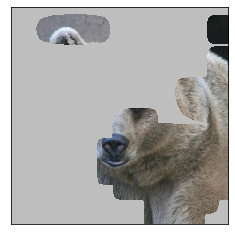

In [152]:
filename = ['brownbear']
for i in filename:
    cutimage(i+'/train',i+'_',i)

In [2]:
def load_array(path):
    temp_list = []
    path_list = os.listdir(path)
    for i in path_list:
        temp = np.load(path +'/'+ i)
        temp_list.append(temp)
    temp_final_img = np.stack((temp_list))
    temp_final_img = temp_final_img.reshape(temp_final_img.shape[0]*temp_final_img.shape[1],temp_final_img.shape[2]*temp_final_img.shape[3]*temp_final_img.shape[4])
    return temp_final_img
def load_short_array(path):
    temp_list = []
#     path_list = os.listdir(path)
    temp = np.load(path)
    plt.imshow(np.uint8(temp)[10])
    temp = temp.reshape(temp.shape[0],temp.shape[1]*temp.shape[2]*temp.shape[3])
    return temp

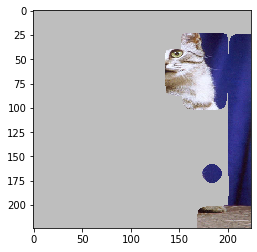

In [3]:
# temp_final_img = load_array("bird/npy")
temp_final_img = load_short_array("Egyptiancat1/npy/Egyptiancat1.npy")

In [4]:
temp_final_img.shape


(512, 150528)

In [180]:
def train_model(features,filename):
    silhouette_ten = []

    # SSE = []
    for i in tqdm(range(0,10)):
        silhouette = []
        for k in tqdm(range(2,11)):
            estimator = KMeans(n_clusters=k)
            cluster_labels = estimator.fit_predict(features)
            estimator.fit(features)
            joblib.dump(estimator,filename+ '/' + filename + str(i) + '_' + str(k) + '.pkl')
            silhouette.append(silhouette_score(features, cluster_labels))
        silhouette_ten.append(silhouette)

    np.save("silhouette_ten.npy",np.array(silhouette_ten))

In [10]:
train_model(temp_final_img,'real_model_bird')

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [11:46:54<00:00, 4241.48s/it]


In [5]:
def plot_silhouette(silhouette):
    colors = ['b','g','r','c','m','y','k','tan','lime','orchid']
    for i,j in zip(silhouette,colors):
        X = range(2,11)
        plt.plot(X,i,'o-',color = j)
    plt.xlabel('k')
    plt.ylabel('silhouette')
    plt.show()

In [6]:
def findindex(filepath,k):
    temp_list = []
    for i in np.load(filepath):
        count = 0
        for j in i:
            count += 1
            if count == k:
                temp_list.append(j)
    print(np.mean(temp_list))
    return temp_list.index(max(temp_list))

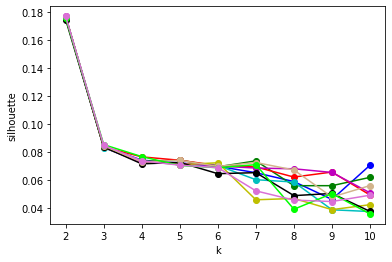

In [7]:
plot_silhouette(np.load("Egyptiancat1/silhouette_ten.npy"))

In [9]:
index = findindex("Egyptiancat1/silhouette_ten.npy",3)
index

0.07360755896309208


8

In [10]:
# def readmodel(model_name,k):
#     model_list = os.listdir(model_name)
#     name_model = []
#     new_kmeans = []
#     for i in model_list:
#         if i != '.DS_Store':
#             if i.split('_')[2].split('.')[0] == str(k):
#                 name_model.append(i)
#     for i in name_model:
#         new_kmeans.append(joblib.load(model_name +'/' + i))
#     return new_kmeans
def readmodel(model_name,k):
    model_list = os.listdir(model_name)
    name_model = []
    new_kmeans = []
    for i in model_list:
        if i != '.DS_Store':
            if i.split('_')[3].split('.')[0] == str(k):
                name_model.append(i)
    for i in name_model:
        new_kmeans.append(joblib.load(model_name +'/' + i))
    return new_kmeans

In [11]:
# new_kmeans = readshortmodel('brownbear/real_model_bear','5')
new_kmeans = readmodel('gazelle/real_model_gazelle','5')
new_kmeans

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorit

In [12]:
def showcluster(k,model_list,index):
    n_clusters = k
    km = model_list[index]
    cluster_elements = [(km.labels_==i).sum() for i in range(n_clusters)]
    plt.bar(range(n_clusters), cluster_elements, width=1)
    return km

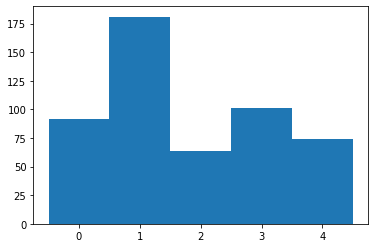

In [13]:
km = showcluster(5,new_kmeans,index)

In [221]:
def readlabel(path):
    result_lists = []
    result_lists_int = []
    result_dict = {}
    result_dict_result = {}
    result_lists_final = []
    path_list = os.listdir(path)
    for i in path_list:
        if i != '.DS_Store':
            result_lists_int.append(int(i.split('-')[0]))
            result_dict[int(i.split('-')[0])] = i.split('-')[1]
    result_lists_int.sort()
    for i in result_lists_int:
        result_dict_result[i] = result_dict[i]
        result_lists.append(str(i) + '-' + result_dict_result[i])
    for i in result_lists:
        result_lists_final.append(i.split('.')[0])
    return result_lists_final
def all_label(path):
    file_name = []
    result_list = []
    for i in os.listdir(path):
        if i != '.DS_Store':
            file_name.append(path+ '/'+ i)
    result_lists = []
    for i in file_name:
        result_lists += readlabel(i)
    return result_lists


In [222]:
result_lists = all_label('label')
result_lists

['0-wbwings&hook',
 '1-yhead&wbwings',
 '2-back',
 '3-yhead&wbwings&hook',
 '4-yhead&wbwings&hook',
 '5-wbwings',
 '6-wbwings',
 '7-yhead&wbwings',
 '8-wbwings',
 '9-yhead&wbwings&hook',
 '10-yhead&wbwings&hook',
 '11-yhead&wbwings',
 '12-wbwings',
 '13-back',
 '14-wbwings&hook',
 '15-wbwings&hook',
 '16-wbwings&hook',
 '17-yhead',
 '18-yhead&wbwings',
 '19-back',
 '20-wbwings',
 '21-wbwings&hook',
 '22-yhead&wbwings&hook',
 '23-wbwings&hook',
 '24-wbwings',
 '25-wbwings',
 '26-back',
 '27-yhead&wbwings&hook',
 '28-wbwings',
 '29-wbwings',
 '30-back',
 '31-wbwings&hook',
 '32-wbwings&hook',
 '33-wbwings',
 '34-back',
 '35-wbwings',
 '36-wbwings&hook',
 '37-yhead&wbwings&hook',
 '38-back',
 '39-yhead',
 '40-back',
 '41-yhead&wbwings',
 '42-back',
 '43-yhead&wbwings',
 '44-yhead',
 '45-yhead&wbwings&hook',
 '46-yhead&wbwings',
 '47-yhead&wbwings',
 '48-yhead&wbwings',
 '49-wbwings',
 '50-wbwings',
 '51-wbwings&hook',
 '52-yhead&wbwings&hook',
 '53-back',
 '54-yhead&wbwings',
 '55-yhead&w

In [223]:
def read_each_cluster(k,image,label,km):
    labels = np.where(km.labels_==k)[0][:]
    cluster_list = []
    temp_result_cluster = []
    for i in labels:
        cluster_list.append(image[i])
        temp_result_cluster.append(label[i].split('-')[1])
    return cluster_list,temp_result_cluster

In [224]:
def summary(km,result_lists):
    list_fianl_group = []
    count_list_group = []
    for i in range(0,5):
        temp_list = []
        labels = np.where(km.labels_==i)[0][:]
        for i in labels:
            temp_list.append(result_lists[i].split('-')[1])
        list_fianl_group.append(temp_list)


    for i in list_fianl_group:
        count_list_group.append(Counter(i))
    return count_list_group,list_fianl_group


In [225]:
count_list,original_list = summary(km,result_lists)
count_list

[Counter({'yhead&wbwings&hook': 74,
          'back': 21,
          'wbwings&hook': 49,
          'yhead': 20,
          'yhead&wbwings': 53,
          'wbwings': 17,
          'hook': 11,
          'yhead&hook': 4}),
 Counter({'wbwings': 61,
          'back': 39,
          'yhead&wbwings': 162,
          'wbwings&hook': 28,
          'yhead&wbwings&hook': 80,
          'yhead&hook': 3,
          'hook': 6,
          'yhead': 14}),
 Counter({'yhead&wbwings': 7,
          'yhead&wbwings&hook': 9,
          'back': 28,
          'hook': 4,
          'wbwings': 10,
          'wbwings&hook': 17,
          'yhead': 6,
          'yhead&hook': 3}),
 Counter({'wbwings&hook': 122,
          'yhead&wbwings': 255,
          'back': 223,
          'yhead&wbwings&hook': 125,
          'wbwings': 177,
          'yhead': 69,
          'hook': 22,
          'yhead&hook': 8}),
 Counter({'yhead&wbwings&hook': 28,
          'wbwings': 59,
          'back': 105,
          'wbwings&hook': 38,
          'yh

In [226]:
def readtestdata(filename):
    test_img = np.load(filename)
    test_img = test_img.reshape(test_img.shape[0],test_img.shape[1]*test_img.shape[2]*test_img.shape[3])
    return test_img

In [228]:
test_img = readtestdata('bird/sbird5.npy')

In [229]:
def predict_test(km,path,test_img):
    final_temp = []
    final_temp_group = []

    predict_lable = readlabel(path)
    predict_m = km.predict(test_img)
    counter_two = {}
    for i in predict_m:
        counter_two.setdefault(i,[])
    for i,j in zip(predict_m,predict_lable):
        counter_two[i].append(j.split('-')[1])
    for i in sorted (counter_two) : 
        final_temp.append(counter_two[i])
    for i in final_temp:
        final_temp_group.append(Counter(i))
    return final_temp_group,predict_m


In [230]:
final_temp_group,predict_m = predict_test(km,'results_bird_5',test_img)

In [231]:
print(final_temp_group)
print(predict_m)

[Counter({'yhead&wbwings': 26, 'yhead&wbwings&hook': 3, 'yhead': 2, 'wbwings': 1}), Counter({'back': 1}), Counter({'back': 141, 'yhead&wbwings': 131, 'wbwings': 36, 'yhead': 28, 'wbwings&hook': 18, 'yhead&wbwings&hook': 14}), Counter({'back': 38, 'wbwings&hook': 20, 'yhead&wbwings': 19, 'yhead&wbwings&hook': 12, 'wbwings': 9, 'hook': 8, 'yhead': 3, 'yhead&hook': 2})]
[3 3 3 1 4 3 3 3 3 3 4 3 3 4 3 3 4 3 1 3 4 3 3 4 3 3 1 1 3 3 3 4 4 3 3 4 4
 4 3 3 4 4 3 3 3 4 3 3 3 3 1 4 3 3 3 1 3 3 3 3 3 3 1 4 3 3 4 3 3 3 3 3 3 3
 3 3 3 4 4 3 3 3 3 4 3 3 3 4 3 3 3 4 3 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 4 3 3 3 3 4 3 3 3 3 1 3 3 3 4 3 3 3 3 3 3 3 1 4 4 4 3 4 3 3 3 1 4 3 3 4 3
 1 3 1 3 4 4 3 4 3 4 4 4 3 4 3 3 3 3 3 4 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 4 4 4 3 4 4 3 3 3 4 3 3 1 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 1 3 3 4 4 3 3 3
 1 3 4 3 3 4 3 3 3 3 2 4 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 1 3 1 3 4 3
 3 4 3 3 3 4 3 3 3 3 1 3 4 3 4 3 3 3 3 3 4 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3
 3 3 3 4 3 3 4 3 4 3 3 3 3 3 3

In [232]:
def group_label(k,predict_m,path):
    clf_group = []
    predict_lable_t = readlabel(path)
    temp_lable_t = []
    for i,j in zip(predict_m,range(0,len(predict_m))):
        if i == k:
            clf_group.append(test_img[j])
            temp_lable_t.append(predict_lable_t[j].split('-')[1])
    return clf_group,temp_lable_t

In [241]:
clf_group,temp_lable_t = group_label(4,predict_m,'results_bird_5')
cluster_list,list_name = read_each_cluster(4,temp_final_img,result_lists,km)

In [242]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(cluster_list, list_name)
final_result = gnb.predict(clf_group)
count = 0
for i,j in zip(final_result,temp_lable_t):
    if i == j:
        count+=1
print(count,len(final_result))
print(count/len(final_result))

30 111
0.2702702702702703


In [16]:
def weightperimg(decision,second,path,km,k):
    weight = example_visualization(decision,second,path)
    index_list = []
    temp_weight = {}
    index_list.append(np.where(km.labels_==k)[0])
    for i in index_list[0]:
        temp_weight[weight[i]] = i
    return sorted(temp_weight.items(),reverse=True)[:10]

In [41]:
topten = weightperimg(False,True,"Egyptiancat1/train/1.JPEG",km,4)
topten

Predicted class:
Egyptian_cat (n02124075) with probability 0.92


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


[(0.45460102, 324),
 (0.25194615, 120),
 (0.24978639, 450),
 (0.20108221, 8),
 (0.1917893, 123),
 (0.18891816, 232),
 (0.1830738, 223),
 (0.16143355, 92),
 (0.15091182, 474),
 (0.1504005, 176)]

In [42]:
# def readlabel_name(path):
#     result_lists = []
#     result_lists_int = []
#     result_lists_final = []
#     path_list = os.listdir(path)
#     for i in path_list:
#         if i != '.DS_Store':
#             if '-' in i:
#                 result_lists_final.append(i)
#             else:
#                 result_lists_int.append(int(i.split('.')[0]))
#     result_lists_int.sort()
#     for i in result_lists_int:
#         result_lists_final.append(str(i) + '.png')
#     return result_lists_final

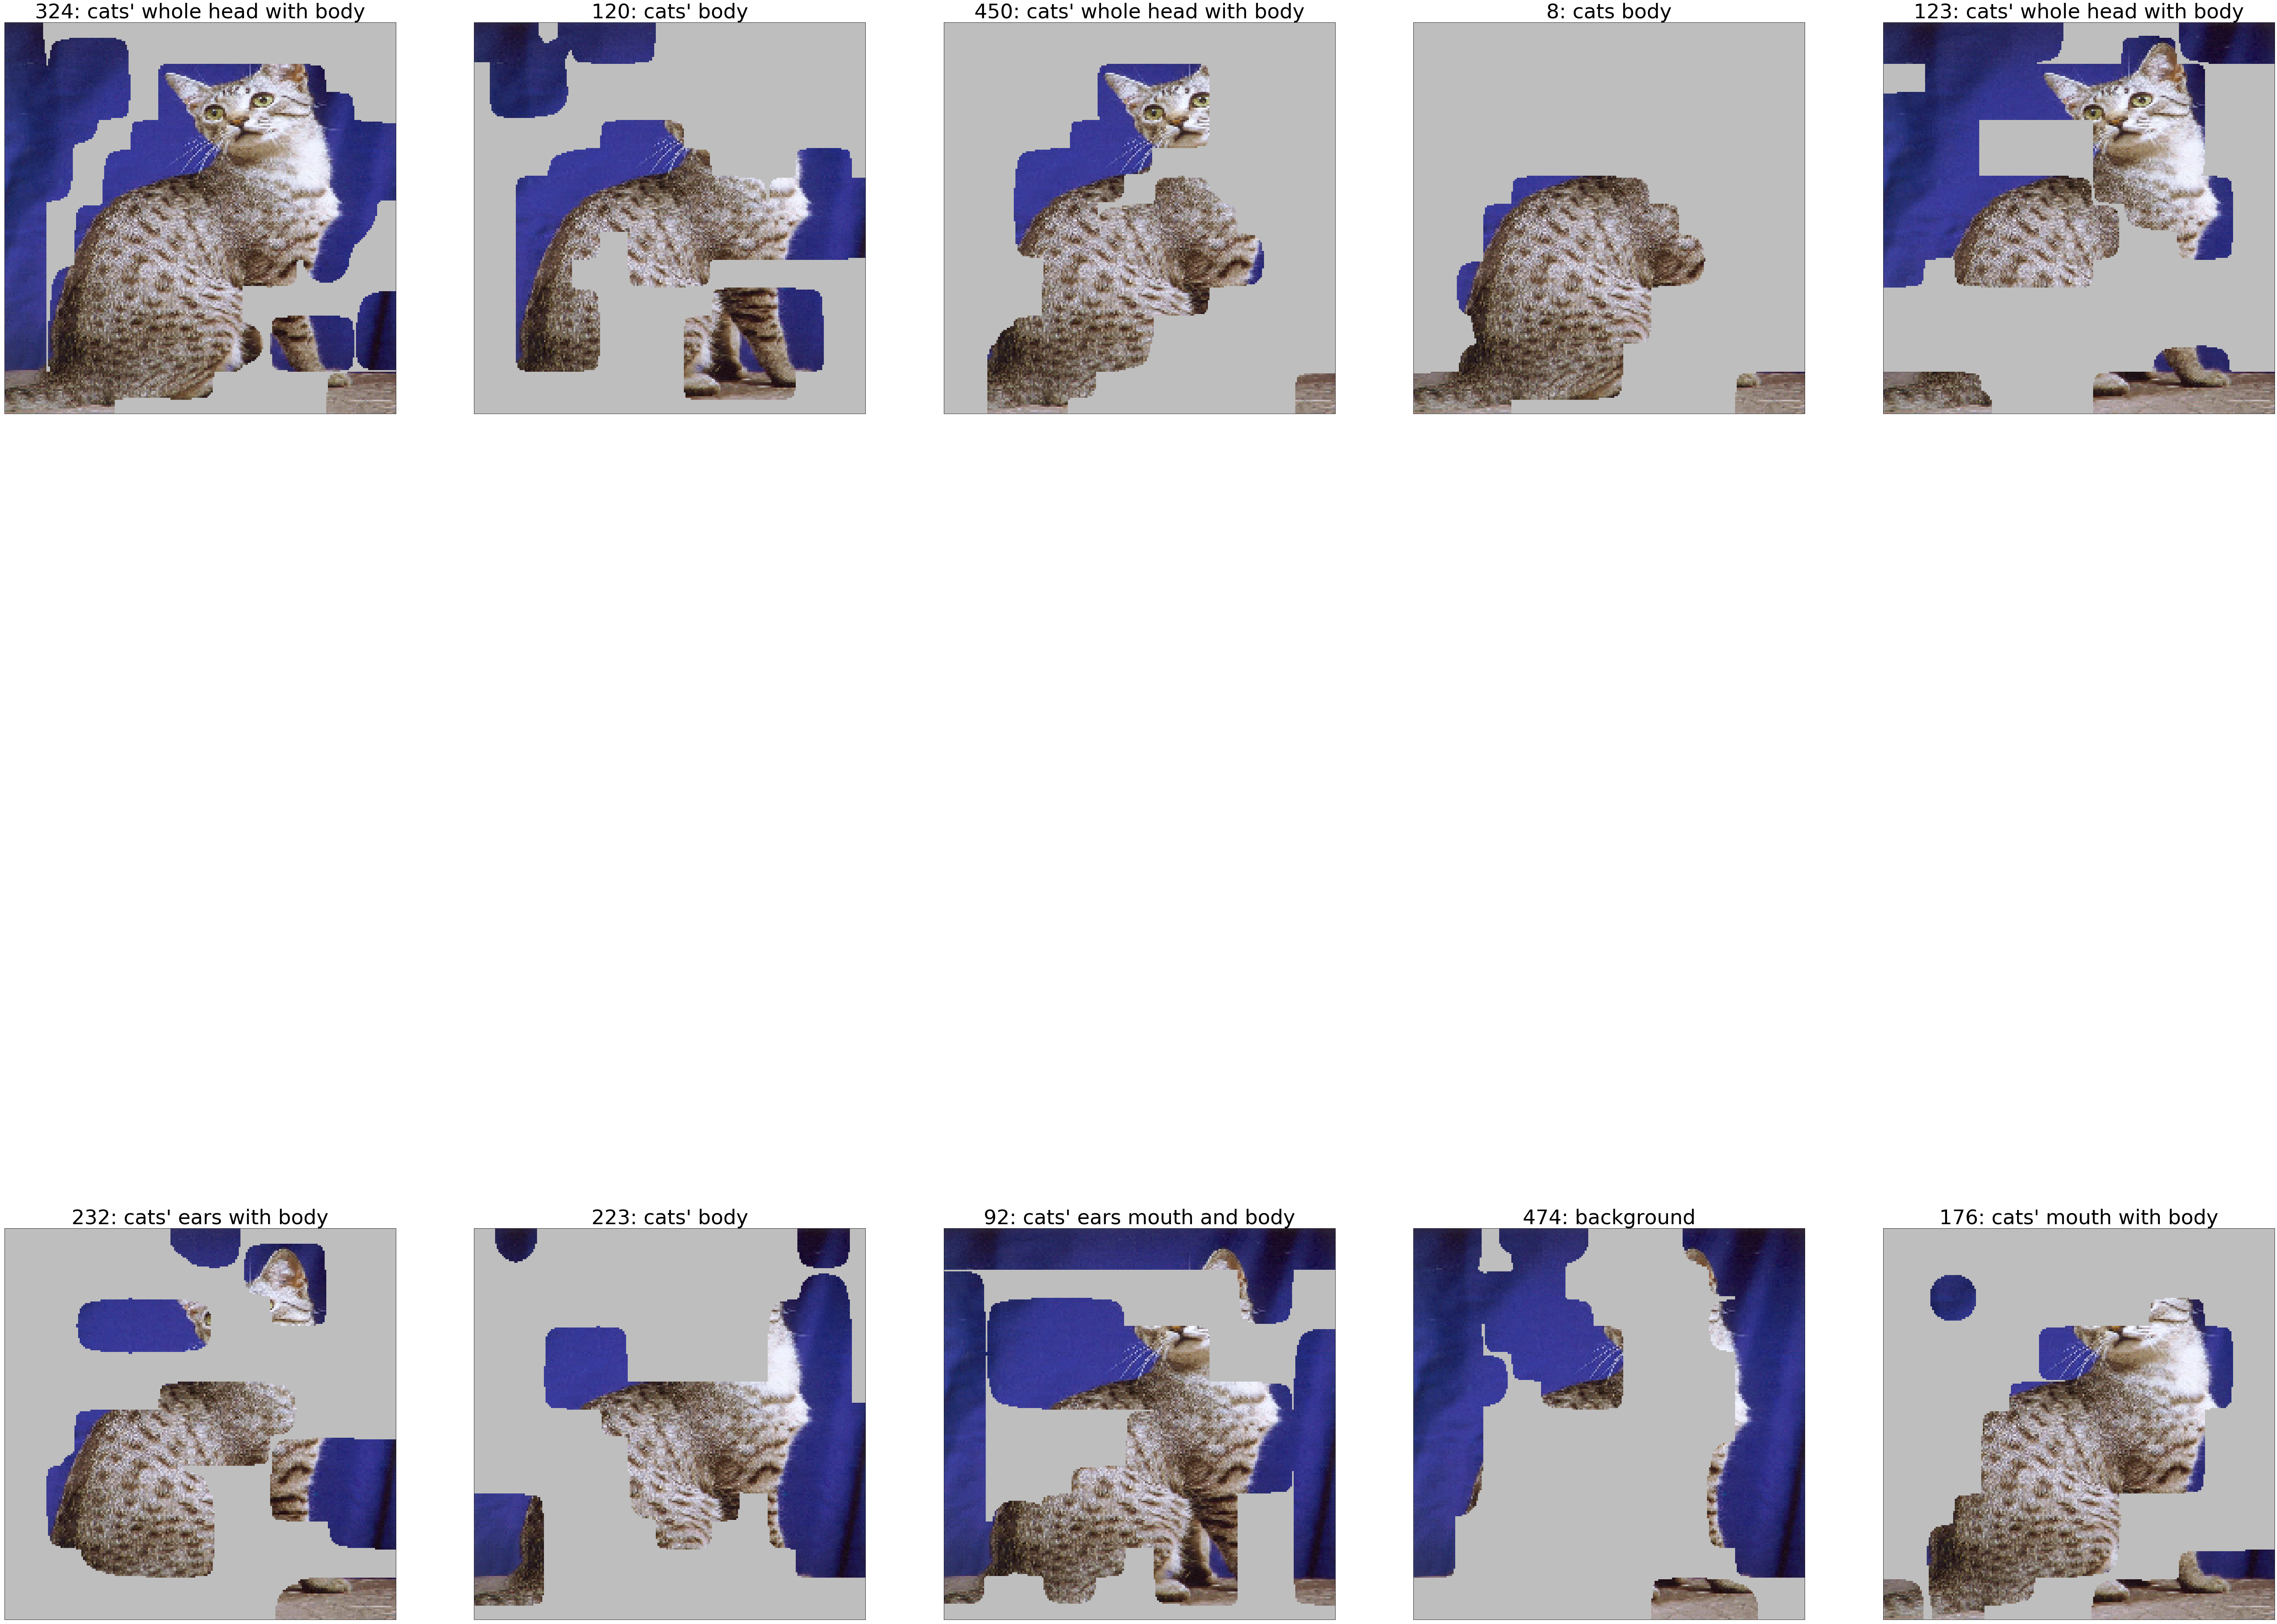

In [44]:
list_ten = ["cats' whole head with body","cats' body"
            ,"cats' whole head with body","cats body","cats' whole head with body",
           "cats' ears with body","cats' body","cats' ears mouth and body"
            ,"background",
            "cats' mouth with body"]
temp_ten = np.load("Egyptiancat1/npy/Egyptiancat1.npy")
fig = plt.figure(figsize=(100, 100))

for i,v in enumerate(temp_ten):
    for k,j in enumerate(topten):
        if i == j[1]:
            
            sub = fig.add_subplot(2, 5, k + 1)
            sub.axes.get_xaxis().set_visible(False)
            sub.axes.get_yaxis().set_visible(False)
            sub.set_title(str(i)+": "+list_ten[k],fontsize=50)
            sub.imshow(v)

In [60]:
import random
result_time = []
for i in range(0,5):
    result_time.append(random.randrange(60,180))


[154, 60, 171, 85, 78]

In [188]:
result_time = [154, 60, 171, 85, 78]
result_time

[154, 60, 171, 85, 78]

In [122]:
result_time_no = []
for i in range(0,5):
    result_time_no.append(random.randrange(90,240))

In [189]:
result_time_no = [92, 204, 120, 220, 190]
result_time_no

[92, 204, 120, 220, 190]

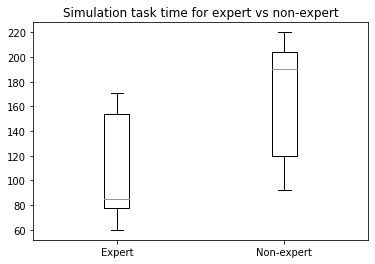

In [190]:
data = [result_time,result_time_no]
fig7, ax7 = plt.subplots()
ax7.set_title('Simulation task time for expert vs non-expert')
ax7.boxplot(data)
plt.xticks([1,2],["Expert", "Non-expert"])
plt.show()

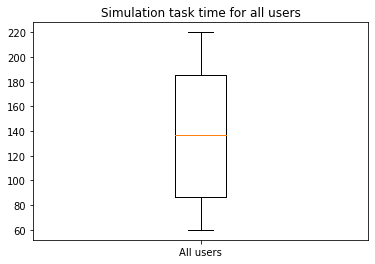

In [141]:
data1 = result_time + result_time_no
fig8, ax8 = plt.subplots()
ax8.set_title('Simulation task time for all users')
ax8.boxplot(data1)
plt.xticks([1],["All users"])
plt.show()

In [157]:
result_time_v = []
for i in range(0,5):
    result_time_v.append(random.randrange(40,180))

In [191]:
result_time_v = [49, 173, 98, 59, 50]
result_time_v

[49, 173, 98, 59, 50]

In [165]:
result_time_d = []
for i in range(0,5):
    result_time_d.append(random.randrange(40,180))

In [192]:
result_time_d = [98, 58, 108, 159, 74]
result_time_d

[98, 58, 108, 159, 74]

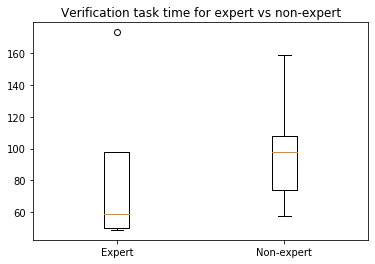

In [193]:
data_1 = [result_time_v,result_time_d]
fig9, ax9 = plt.subplots()
ax9.set_title('Verification task time for expert vs non-expert')
ax9.boxplot(data_1)
plt.xticks([1,2],["Expert", "Non-expert"])
plt.show()

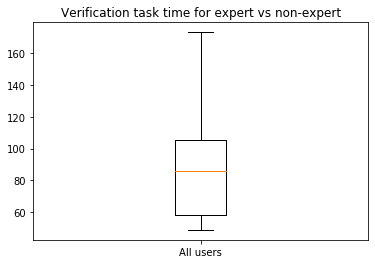

In [178]:
data_2 = result_time_v+result_time_d
fig10, ax10 = plt.subplots()
ax10.set_title('Verification task time for expert vs non-expert')
ax10.boxplot(data_2)
plt.xticks([1],["All users"])
plt.show()

In [180]:
result_time_k = []
for i in range(0,5):
    result_time_k.append(random.randrange(120,180))

In [181]:
result_time_k = [177, 164, 172, 149, 123]

[177, 164, 172, 149, 123]

In [182]:
result_time_z = []
for i in range(0,5):
    result_time_z.append(random.randrange(150,300))

In [183]:
result_time_z = [243, 219, 166, 174, 298]

[243, 219, 166, 174, 298]

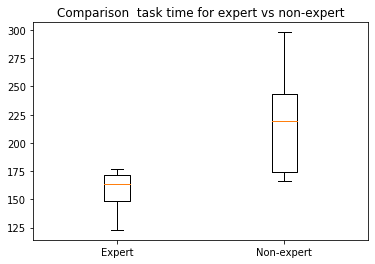

In [187]:
data_2 = [result_time_k,result_time_z]
fig9, ax9 = plt.subplots()
ax9.set_title('Comparison  task time for expert vs non-expert')
ax9.boxplot(data_2)
plt.xticks([1,2],["Expert", "Non-expert"])
plt.show()

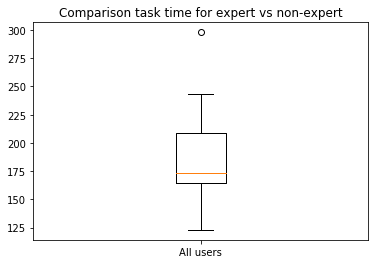

In [186]:
data_3 = result_time_k+result_time_z
fig10, ax10 = plt.subplots()
ax10.set_title('Comparison task time for expert vs non-expert')
ax10.boxplot(data_3)
plt.xticks([1],["All users"])
plt.show()